In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools

from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
from tqdm.notebook import trange, tqdm
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR

import matplotlib.pyplot as plt

from torchvision.utils import make_grid

from lpips import LPIPS

from torch.utils.data import TensorDataset
from einops import rearrange
import math

In [14]:
def marginal_prob_std(t, sigma, device='cuda'):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  
  
  Returns:
    The standard deviation.
  """    
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))


def diffusion_coeff(t, sigma, device='cpu'):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.
  
  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)


def Euler_Maruyama_sampler(score_model, 
              marginal_prob_std,
              diffusion_coeff, 
              batch_size=64, 
              x_shape=(1, 28, 28),
              num_steps=500, 
              device='cuda', 
              eps=1e-3, y=None):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.
  
  Returns:
    Samples.    
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, *x_shape, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, y=y) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      
  # Do not include any noise in the last sampling step.
  return mean_x


class WordEmbed(nn.Module):
  def __init__(self, vocab_size, embed_dim):
    super(WordEmbed, self).__init__()
    self.embed = nn.Embedding(vocab_size+1, embed_dim)
  
  def forward(self, ids):
    return self.embed(ids)


class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights (frequencies) during initialization. 
    # These weights (frequencies) are fixed during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    # Cosine(2 pi freq x), Sine(2 pi freq x)
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps.
  Allow time repr to input additively from the side of a convolution layer.
  """
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None] 
    # this broadcast the 2d tensor to 4d, add the same value across space. 
  
class CrossAttention(nn.Module):
  def __init__(self, embed_dim, hidden_dim, context_dim=None, num_heads=1,):
    """
    Note: For simplicity reason, we just implemented 1-head attention. 
    Feel free to implement multi-head attention! with fancy tensor manipulations.
    """
    super(CrossAttention, self).__init__()
    self.hidden_dim = hidden_dim
    self.context_dim = context_dim
    self.embed_dim = embed_dim
    self.query = nn.Linear(hidden_dim, embed_dim, bias=False)
    if context_dim is None:
      self.self_attn = True 
      self.key = nn.Linear(hidden_dim, embed_dim, bias=False)     ###########
      self.value = nn.Linear(hidden_dim, hidden_dim, bias=False)  ############
    else:
      self.self_attn = False 
      self.key = nn.Linear(context_dim, embed_dim, bias=False)   #############
      self.value = nn.Linear(context_dim, hidden_dim, bias=False) ############
    
    
  def forward(self, tokens, context=None):
    # tokens: with shape [batch, sequence_len, hidden_dim]
    # context: with shape [batch, contex_seq_len, context_dim]
    if self.self_attn:
        Q = self.query(tokens)
        K = self.key(tokens)  
        V = self.value(tokens) 
    else:
        # implement Q, K, V for the Cross attention 
        Q = self.query(tokens)
        K = self.key(context)  
        V = self.value(context) 
    #print(Q.shape, K.shape, V.shape)
    ####### YOUR CODE HERE (2 lines)
    scoremats = torch.einsum("bij,bkj->bik" ,Q , K)     # inner product of Q and K, a tensor 
    attnmats = F.softmax(scoremats/(len(Q)**0.5))          # softmax of scoremats
    #print(scoremats.shape, attnmats.shape, )
    ctx_vecs = torch.einsum("BTS,BSH->BTH", attnmats, V)  # weighted average value vectors by attnmats
    return ctx_vecs


class TransformerBlock(nn.Module):
  """The transformer block that combines self-attn, cross-attn and feed forward neural net"""
  def __init__(self, hidden_dim, context_dim):
    super(TransformerBlock, self).__init__()
    self.attn_self = CrossAttention(hidden_dim, hidden_dim, )
    self.attn_cross = CrossAttention(hidden_dim, hidden_dim, context_dim)

    self.norm1 = nn.LayerNorm(hidden_dim)
    self.norm2 = nn.LayerNorm(hidden_dim)
    self.norm3 = nn.LayerNorm(hidden_dim)
    # implement a 2 layer MLP with K*hidden_dim hidden units, and nn.GeLU nonlinearity #######
    K = 4
    self.ffn  = nn.Sequential(
        # YOUR CODE HERE ##################
        nn.Linear(hidden_dim, K * hidden_dim),
        nn.GELU(),
        nn.Linear(K * hidden_dim, hidden_dim)
    )
    
  def forward(self, x, context=None):
    # Notice the + x as residue connections
    x = self.attn_self(self.norm1(x)) + x
    # Notice the + x as residue connections
    x = self.attn_cross(self.norm2(x), context=context) + x
    # Notice the + x as residue connections
    x = self.ffn(self.norm3(x)) + x
    return x 


class SpatialTransformer(nn.Module):
  def __init__(self, hidden_dim, context_dim):
    super(SpatialTransformer, self).__init__()
    self.transformer = TransformerBlock(hidden_dim, context_dim)

  def forward(self, x, context=None):
    b, c, h, w = x.shape
    x_in = x
    # Combine the spatial dimensions and move the channel dimen to the end
    x = rearrange(x, "b c h w->b (h w) c")
    # Apply the sequence transformer
    x = self.transformer(x, context)
    # Reverse the process
    x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
    # Residue 
    return x + x_in

class UNet_Tranformer(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256, 
                text_dim=256, nClass=10):
        """Initialize a time-dependent score-based network.

        Args:
        marginal_prob_std: A function that takes time t and gives the standard
            deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
        channels: The number of channels for feature maps of each resolution.
        embed_dim: The dimensionality of Gaussian random feature embeddings of time.
        text_dim:  the embedding dimension of text / digits. 
        nClass:    number of classes you want to model.
        """
        super().__init__()
        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
            )
        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.attn3 = SpatialTransformer(channels[2], text_dim) 
        
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    
        # YOUR CODE: interleave some attention layers with conv layers
        self.attn4 = SpatialTransformer(channels[3], text_dim) 

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])   

        self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)     #  + channels[2]
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        
        self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)     #  + channels[1]
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1) #  + channels[0]
        
        # The swish activation function
        self.act = nn.SiLU() # lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std
        self.cond_embed = nn.Embedding(nClass, text_dim)
    
    def forward(self, x, t, y=None): 
        # Obtain the Gaussian random feature embedding for t   
        embed = self.act(self.time_embed(t))    
        y_embed = self.cond_embed(y).unsqueeze(1)
        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed) 
        ## Incorporate information from t
        ## Group normalization
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h3 = self.attn3(h3, y_embed) # Use your attention layers
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))
        # Your code: Use your additional attention layers! 
        h4 = self.attn4(h4, y_embed)       ##################### ATTENTION LAYER COULD GO HERE IF ATTN4 IS DEFINED

        # Decoding path
        h = self.tconv4(h4) + self.dense5(embed)
        ## Skip connection from the encoding path
        h = self.act(self.tgnorm4(h))
        h = self.tconv3(h + h3) + self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(h + h2) + self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(h + h1)

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h
    
class Latent_UNet_Tranformer(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[4, 64, 128, 256], embed_dim=256, 
               text_dim=256, nClass=10):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.time_embed = nn.Sequential(
        GaussianFourierProjection(embed_dim=embed_dim),
        nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(channels[0], channels[1], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[1])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[1])
    self.conv2 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[2])
    self.gnorm2 = nn.GroupNorm(4, num_channels=channels[2])
    self.attn2 = SpatialTransformer(channels[2], text_dim)
    self.conv3 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[3])
    self.gnorm3 = nn.GroupNorm(4, num_channels=channels[3])   
    self.attn3 = SpatialTransformer(channels[3], text_dim) 
    
    self.tconv3 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False, )    
    self.dense6 = Dense(embed_dim, channels[2])
    self.tgnorm3 = nn.GroupNorm(4, num_channels=channels[2])
    self.attn6 = SpatialTransformer(channels[2], text_dim)
    self.tconv2 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)     # + channels[2]
    self.dense7 = Dense(embed_dim, channels[1])
    self.tgnorm2 = nn.GroupNorm(4, num_channels=channels[1])
    self.tconv1 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=1) # + channels[1]
    
    # The swish activation function
    self.act = nn.SiLU() # lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
    self.cond_embed = nn.Embedding(nClass, text_dim)
  
  def forward(self, x, t, y=None): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.time_embed(t))    
    y_embed = self.cond_embed(y).unsqueeze(1)
    # Encoding path
    ## Incorporate information from t
    h1 = self.conv1(x) + self.dense1(embed)
    ## Group normalization
    h1 = self.act(self.gnorm1(h1))
    h2 = self.conv2(h1) + self.dense2(embed)
    h2 = self.act(self.gnorm2(h2))
    h2 = self.attn2(h2, y_embed)
    h3 = self.conv3(h2) + self.dense3(embed)
    h3 = self.act(self.gnorm3(h3))
    h3 = self.attn3(h3, y_embed)

    # Decoding path
    ## Skip connection from the encoding path
    h = self.tconv3(h3) + self.dense6(embed)
    h = self.act(self.tgnorm3(h))
    h = self.attn6(h, y_embed)
    h = self.tconv2(h + h2)
    h += self.dense7(embed)
    h = self.act(self.tgnorm2(h))
    h = self.tconv1(h + h1)

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None].to('cuda')
    return h


class AutoEncoder(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, channels=[4, 8, 32],):
    """Initialize a time-dependent score-based network.
    Args:
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    # Encoding layers where the resolution decreases
    self.encoder = nn.Sequential(nn.Conv2d(1, channels[0], 3, stride=1, bias=True),
                   nn.BatchNorm2d(channels[0]),
                   nn.SiLU(),
                   nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=True),
                   nn.BatchNorm2d(channels[1]),
                   nn.SiLU(),
                   nn.Conv2d(channels[1], channels[2], 3, stride=1, bias=True),
                   nn.BatchNorm2d(channels[2]),
                   ) #nn.SiLU(),
    self.decoder = nn.Sequential(nn.ConvTranspose2d(channels[2], channels[1], 3, stride=1, bias=True),
                   nn.BatchNorm2d(channels[1]),
                   nn.SiLU(),
                   nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=True, output_padding=1),
                   nn.BatchNorm2d(channels[0]),
                   nn.SiLU(),
                   nn.ConvTranspose2d(channels[0], 1, 3, stride=1, bias=True),
                   nn.Sigmoid(),)
  
  def forward(self, x):
    return self.decoder(self.encoder(x))

In [15]:
## Load the pre-trained checkpoint from disk.
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma, device=device)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma, device=device)

# continue_training = False #@param {type:"boolean"}
# if not continue_training:
#   print("initilize new score model...")
#   score_model = torch.nn.DataParallel(UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn))


# ckpt = torch.load('ckpt_transformer.pth', map_location=device)
# score_model.load_state_dict(ckpt)
# digit = 4 #@param {'type':'integer'}
# sample_batch_size = 64 #@param {'type':'integer'}
# num_steps = 250 #@param {'type':'integer'}
# sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
# # score_model.eval()
# ## Generate samples using the specified sampler.
# samples = sampler(score_model, 
#         marginal_prob_std_fn,
#         diffusion_coeff_fn, 
#         sample_batch_size, 
#         num_steps=num_steps,
#         device=device,
#         y=digit*torch.ones(sample_batch_size, dtype=torch.long))

# ## Sample visualization.
# samples = samples.clamp(0.0, 1.0)
# %matplotlib inline
# import matplotlib.pyplot as plt
# sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

# plt.figure(figsize=(6,6))
# plt.axis('off')
# plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
# plt.show()

/tmp/ipykernel_976299/2113906956.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipykernel_976299/2113906956.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)
/tmp/ipykernel_976299/2113906956.py:137: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attnmats = F.softmax(scoremats/(len(Q)**0.5))          # softmax of scoremats


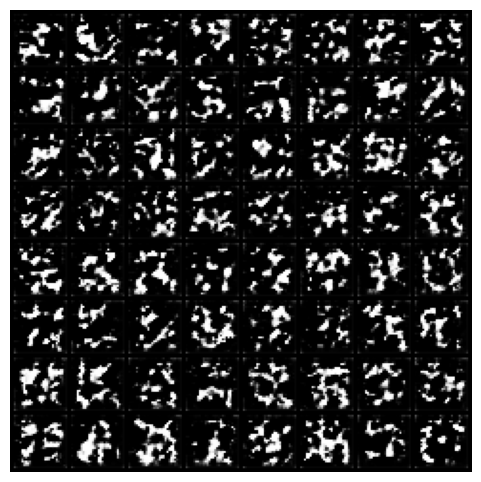

In [42]:
device = 'cuda'
latent_score_model = torch.nn.DataParallel(
    Latent_UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn,
                channels=[4, 16, 32, 64, 128, 256, 512], ))
latent_score_model = latent_score_model.to(device)
ckpt = torch.load('ckpt_transformer_latent.pth', map_location=device)
latent_score_model.load_state_dict(ckpt)

ae_model = AutoEncoder([4, 4, 4]).cuda()
ae_ckpt = torch.load('ckpt_ae.pth', map_location=device)
ae_model.load_state_dict(ae_ckpt)
ae_model.eval()

digit = 8 #@param {'type':'integer'}
sample_batch_size = 64 #@param {'type':'integer'}
num_steps = 250 #@param {'type':'integer'}
sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
latent_score_model.eval()
## Generate samples using the specified sampler.
samples_z = sampler(latent_score_model, 
        marginal_prob_std_fn,
        diffusion_coeff_fn, 
        sample_batch_size, 
        num_steps=num_steps,
        device=device,
        x_shape=(4,10,10),
        y=digit*torch.ones(sample_batch_size, dtype=torch.long))

## Sample visualization.
decoder_samples = ae_model.decoder(samples_z).clamp(0.0, 1.0)
sample_grid = make_grid(decoder_samples, nrow=int(np.sqrt(sample_batch_size)))
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()